# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
# Generator config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of service requests generated: 15


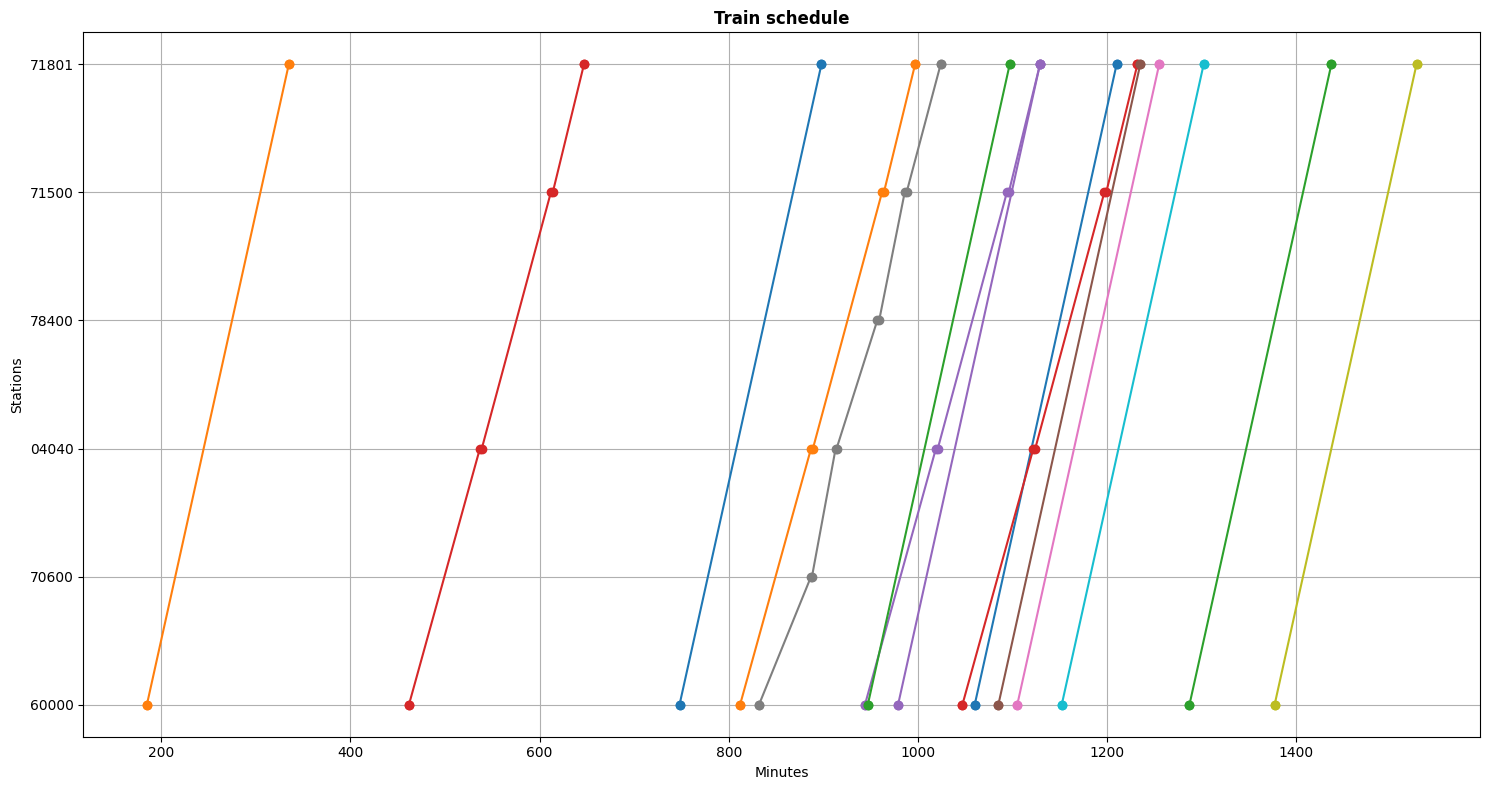

  0%|          | 0/11 [00:00<?, ?it/s]

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.)
7,8.0,2776.187604,1.087058,15.0,46.0,18.0
9,10.0,2729.730057,1.090013,14.0,23.0,9.0
3,4.0,2728.588013,1.101057,15.0,34.0,45.0
5,6.0,2653.733161,1.091171,14.0,21.0,40.0
6,7.0,2644.998941,1.099555,14.0,33.0,32.0
8,9.0,2629.387002,1.060639,14.0,16.0,38.0
2,3.0,2588.844194,1.072419,14.0,24.0,45.0
10,11.0,2531.900384,1.078896,13.0,13.0,44.0
1,2.0,2528.671160,1.076945,13.0,21.0,29.0
4,5.0,2515.157877,1.098504,13.0,6.0,44.0


Global GSA status:
	Total execution time: 11.9743 s.
	Execution Time (by run) - Mean: 1.0886 s. - Std: 0.0159 s.
	Revenue - Mean: 2618.9536 - Std: 98.6767
	Scheduled Trains - Mean: 14.0 - Std: 1.0
	Median solution: Run 1
	Max Revenue: 2959.0 - WARNING!: Scheduling all services could not be feasible


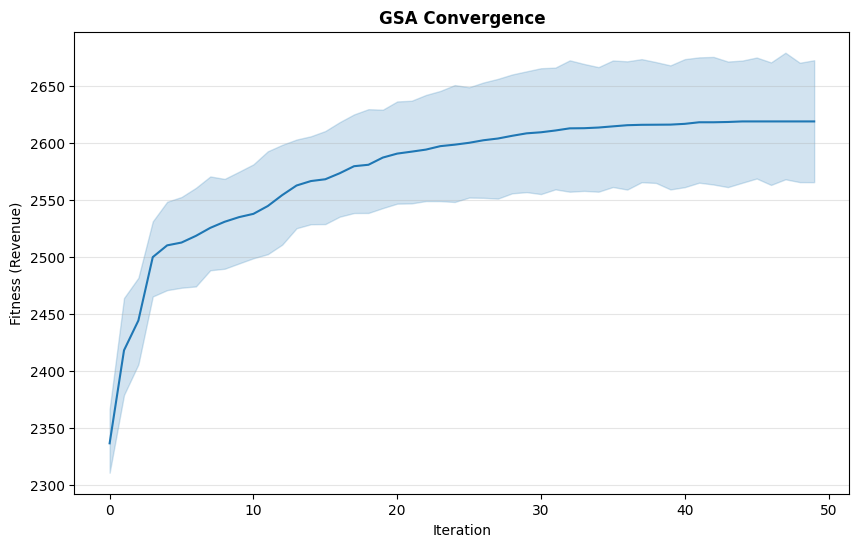

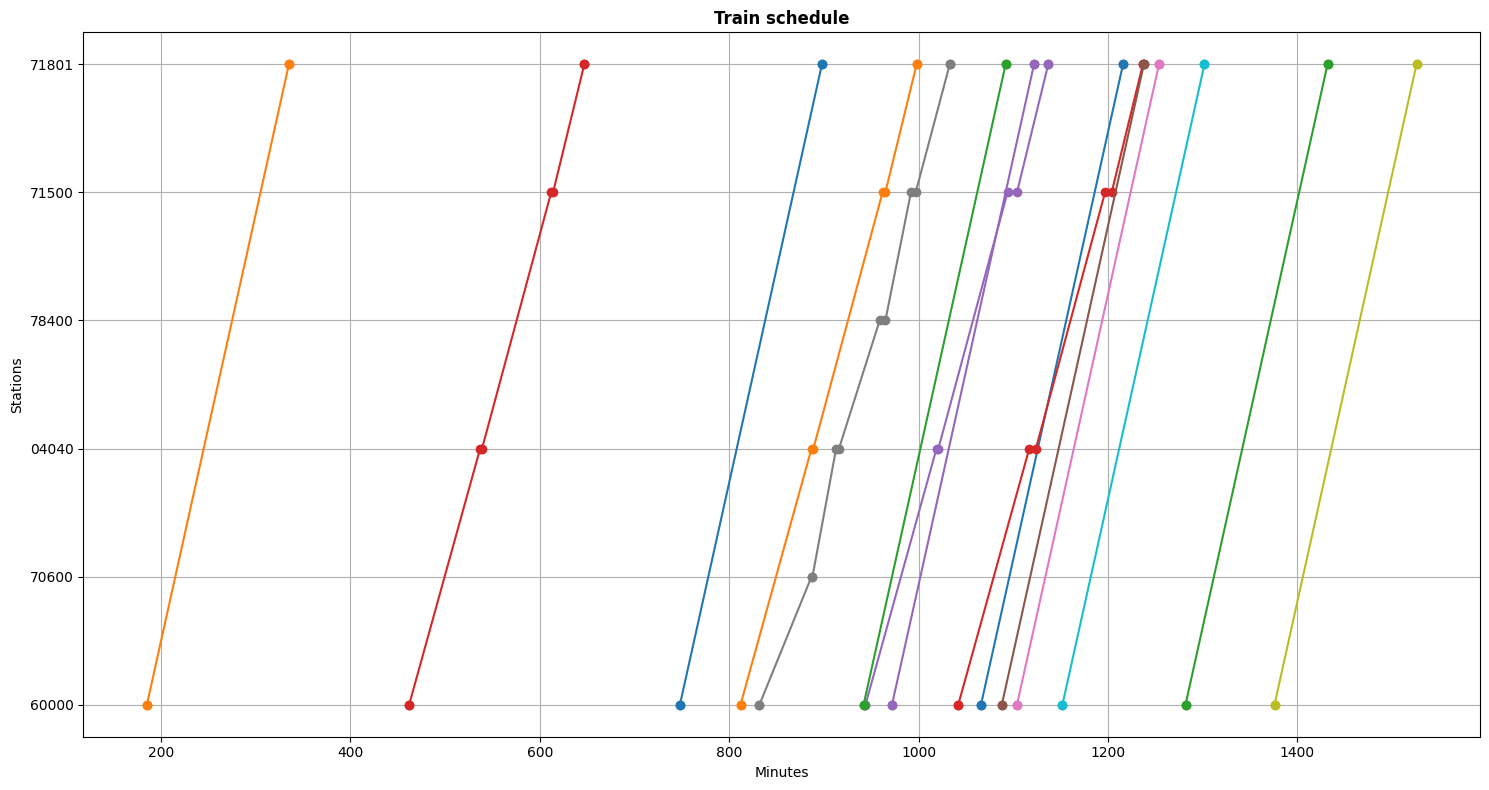

Data from demand plot: 
	Status: User bought a service which was not the one with the best utility. - Passengers: 3669
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 3462
	Status: User bought the ticket with best utility. - Passengers: 914
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4583
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 800 - Percentage: 17.46 %
		Seat: Turista - Passengers: 3483 - Percentage: 76.0 %
		Seat: Turista Plus - Passengers: 300 - Percentage: 6.55 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4583
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 148
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 23
			Seat: Turista - Number of tickets sold: 119
		Date: 2023-06-13
			Seat: Premium - Number of tickets sold: 27
			Seat: Turista

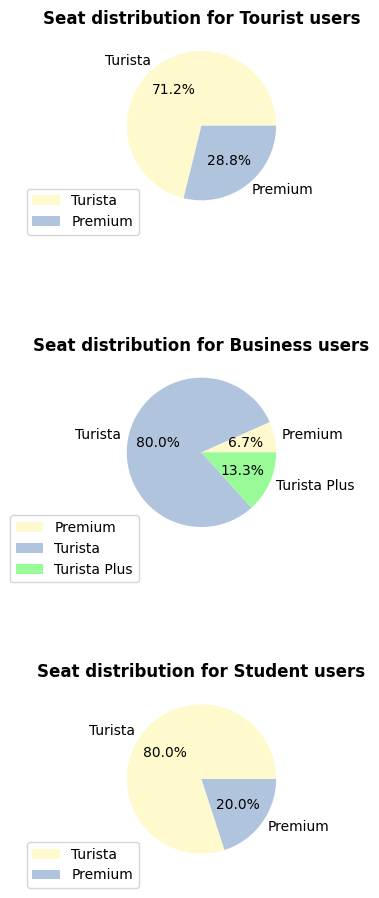

In [9]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path = Path(f'../data/supply_dummy.yml'),
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=f'{robin_save_path}output.yml',
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0
